# Importing packages

In [1]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v3 import StepByStep
from data_generation.rps import download_rps

# Downloading data

In [2]:
# download_rps()

# Data preparation

In [3]:
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

In [4]:
temp_dataset[0][0].shape

torch.Size([3, 28, 28])

In [5]:
len(temp_dataset)

2520

In [6]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [7]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [8]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

In [9]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer


Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

In [10]:
composer = Compose([
    Resize(28),
    ToTensor(),
    normalizer
])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

# Model class

In [11]:
class CNN2(nn.Module):

    def __init__(self, n_filters, p=0.0):
        super(CNN2, self).__init__()

        self.n_filters = n_filters
        self.p = p

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=self.n_filters,
            kernel_size=3
        )

        self.conv2 = nn.Conv2d(
            in_channels=self.n_filters,
            out_channels=self.n_filters,
            kernel_size=3
        )

        self.fc1 = nn.Linear(self.n_filters * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = nn.Flatten()(x)
        
        return x
    
    def classifier(self, x):

        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x
    
    def forward(self, x):

        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Model configuration

In [18]:
karp_const = 3e-4

torch.manual_seed(13)

model_cnn2 = CNN2(n_filters=5, p=0.3)

loss_fn = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.Adam(model_cnn2.parameters(), lr=karp_const)

# Model training

In [19]:
sbs_cnn2 = StepByStep(model_cnn2, loss_fn, optimizer)
sbs_cnn2.set_loaders(train_loader, val_loader)
sbs_cnn2.train(10)

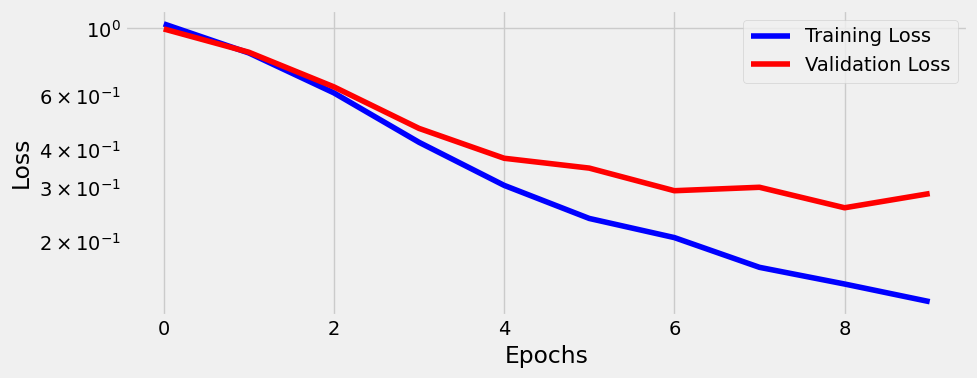

In [20]:
fig = sbs_cnn2.plot_losses()

In [21]:
StepByStep.loader_apply(val_loader, sbs_cnn2.correct)

tensor([[ 93, 124],
        [119, 124],
        [115, 124]])

# Visualizing the filters

In [22]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

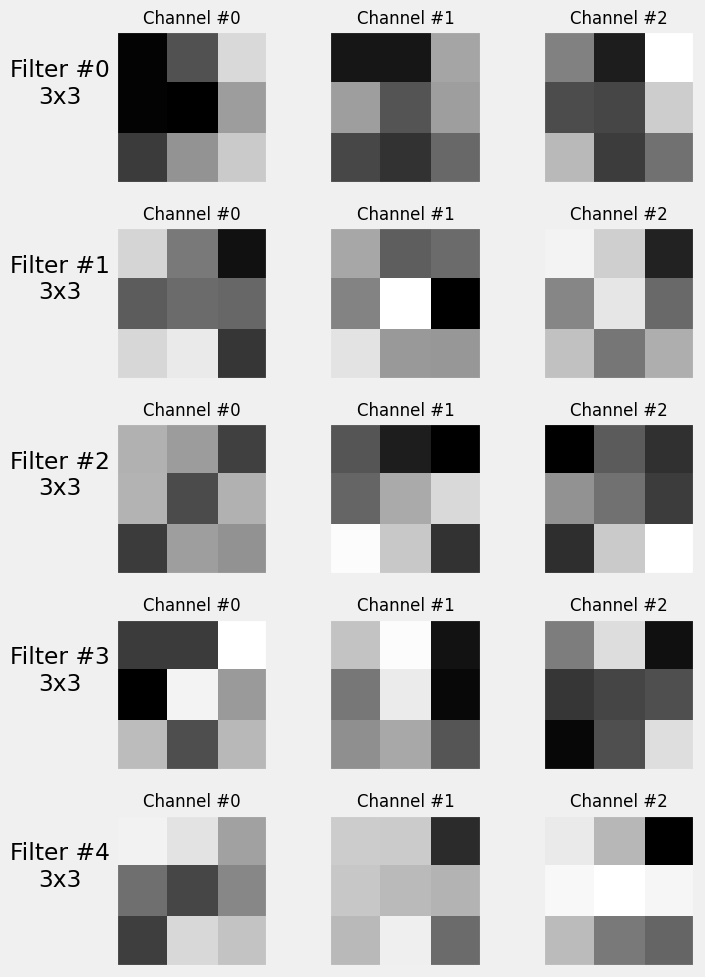

In [23]:
fig = sbs_cnn2.visualize_filters('conv1')

In [24]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

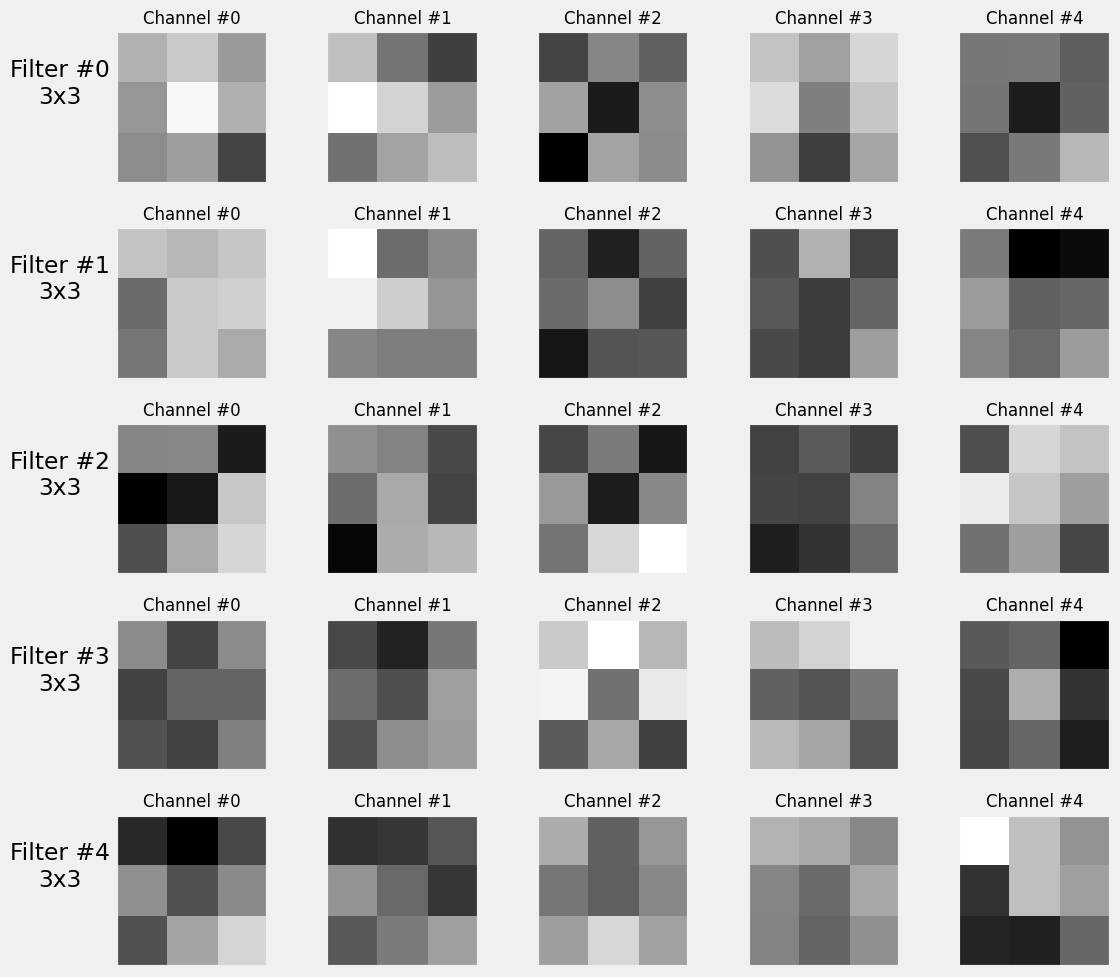

In [25]:
fig = sbs_cnn2.visualize_filters('conv2')